In [1]:
% matplotlib inline

import pandas as pd
import glob, os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('talk')

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Prepare and merge meta information

In [2]:
# doc_dir = '/nobackup/adenauer2/LSD/Originals/Documentation'
doc_dir = '/Users/dmargulies/Downloads'

# study B
df_lsd = pd.read_csv('%s/meta_lsd_restricted_20170315.csv' % doc_dir,
                      dtype={'ids':str})

# study A
df_lemon1 = pd.read_excel('%s/meta1_lemon_restricted_20170321.xls' % doc_dir)

df_lemon1.rename(columns={'BIDS ID': 'ids',
                          'Gender': 'gender',
                          'Age': 'age'}, inplace=True)
df_lemon1[['ids']] = df_lemon1[['ids']].astype(str)
d = {'F':1, 'M':2, 'f':1, 'm':2}
df_lemon1.replace({'gender': d}, inplace=True)


# merge gender/age
df = pd.merge(df_lsd, df_lemon1, on='ids', how='outer')

# gender
df['gender_x'][df['gender_x'].isnull()] = df['gender_y'][df['gender_x'].isnull()]
df['gender_y'][df['gender_y'].isnull()] = df['gender_x'][df['gender_y'].isnull()]
df['gender'] = df['gender_x'].astype(int)

# age
cols_age = ['age day 1', 'age day 2', 'age day 3', 'age day 4',
            'age day 5a', 'age day 5b', 'age day 6', 'age LEMON', 'age']

df['mean age'] = df[cols_age].mean(axis=1)

age_bins = [20, 25, 30, 35, 40, 45, 50, 
            55, 60, 65, 70, 75, 80, 85]
age_labels = ['20-25', '25-30', '30-35', '35-40', 
              '40-45', '45-50', '50-55', '55-60', 
              '60-65', '65-70', '70-75', '75-80', '80-85']

df['age (5-year bins)'] = pd.cut(df['mean age'], age_bins, labels=age_labels)

# clean df
df_meta = df[['ids', 'gender', 'age (5-year bins)', 'mean age',
              'SKID diagnose 1', 'SKID diagnose 2',
              'drug test 1 (before first MRI measurement)',
              'drug test 2 (before 4 resting state scans)']]


# SKID and drug test
df_lemon2 = pd.read_csv('%s/meta2_lemon_restricted_20170315.csv' % doc_dir, dtype = {'ID':str})
df_lemon2.rename(columns={'ID': 'ids'}, inplace=True)

# merge
df_meta = pd.merge(df_meta, 
                   df_lemon2[['ids', 'DRUG', 'SKID_Diagnoses 1', 'SKID_Diagnoses 2']], 
                   on=('ids'), how='outer')

df_meta['ids'] = df_meta['ids'].map(lambda x: '0'+x)

# SKID: reporting lemon by default, only if no lemon skid available, report our skid
# us: 'SKID diagnose 1', 'SKID diagnose 2'
# lemon: 'SKID_Diagnoses 1', 'SKID_Diagnoses 2' 
df_meta['SKID_Diagnoses 1'][df_meta['SKID_Diagnoses 1'].isnull()] = df_meta['SKID diagnose 1'][df_meta['SKID_Diagnoses 1'].isnull()]
df_meta['SKID_Diagnoses 2'][df_meta['SKID_Diagnoses 2'].isnull()] = df_meta['SKID diagnose 2'][df_meta['SKID_Diagnoses 2'].isnull()]

df_meta.rename(columns={'SKID_Diagnoses 1': 'SKID diagnosis 1',
                        'SKID_Diagnoses 2': 'SKID diagnosis 2'}, inplace=True)

# drug test
df_meta[['drug test 1 (before first MRI measurement)']] = df_meta[['DRUG']]

/Applications/miniconda3/envs/topography/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/miniconda3/envs/topography/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/miniconda3/envs/topography/lib/python2.7/site-packages/ipykernel/__main__.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/miniconda3/envs/topography/lib/python2.7/site-packages/ipyk

In [3]:
'''
# study progress

# (interval between days) 
# won't be reported in main meta file
# will be provided upon request

# Questionnaire set 1 (institute)
fileA = '/nobackup/adenauer2/LSD/Originals/Raw/Questionnaires/surveyA_151013.csv'
df_A = pd.read_csv(fileA)
df_A['ids'] = df_A['ID'].map(lambda x: str(x)[0:5])
df_A['B Quest set 1'] = pd.to_datetime(df_A['datestamp'], format='%Y-%m-%d %H:%M:%S')

# Questionnaire set 2 (home)
fileB = '/nobackup/adenauer2/LSD/Originals/Raw/Questionnaires/surveyB_151013.csv'
df_B = pd.read_csv(fileB)
df_B['ids'] = df_B['ID'].map(lambda x: str(x)[0:5])    
df_B['B Quest set 2'] = pd.to_datetime(df_B['datestamp'], format='%Y-%m-%d %H:%M:%S')
df = pd.merge(df_A[['ids', 'B Quest set 1']], df_B[['ids', 'B Quest set 2']], on=['ids'], how='outer')
del df_A, df_B

# Questionnaire set 3 (scanning day)
fileC_active = '/nobackup/adenauer2/LSD/Originals/Raw/Questionnaires/surveyCactive_151013.csv'
fileC_inactive = '/nobackup/adenauer2/LSD/Originals/Raw/Questionnaires/surveyCinactive_151013.csv'
fileC_corrected = '/nobackup/adenauer2/LSD/Originals/Raw/Questionnaires/surveyCcorrected_151013.csv'
df_C_active = pd.read_csv(fileC_active)
df_C_inactive = pd.read_csv(fileC_inactive)
df_C_corrected = pd.read_csv(fileC_corrected)
df_C = pd.concat([df_C_active, df_C_inactive, df_C_corrected])
df_C['ids'] = df_C['ID'].map(lambda x: str(x)[0:5])
df_C['B Quest set 3'] = pd.to_datetime(df_C['datestamp'], format='%Y-%m-%d %H:%M:%S')
df = pd.merge(df, df_C[['ids', 'B Quest set 3']], on=['ids'], how='outer')
del df_C
    
# Questionnaire set 4 (lemon catch up for newbies)
fileF = '/nobackup/adenauer2/LSD/Originals/Raw/Questionnaires/surveyF_151013.csv'
df_F = pd.read_csv(fileF)
df_F['ids'] = df_F['ID'].map(lambda x: str(x)[0:5])
df_F['B Quest set 4a'] = pd.to_datetime(df_F['datestamp'], format='%Y-%m-%d %H:%M:%S')
df = pd.merge(df, df_F[['ids', 'B Quest set 4a']], on=['ids'], how='outer')
del df_F

# Questionnaire set 4 (AMAS) 
fileG = '/nobackup/adenauer2/LSD/Originals/Raw/Questionnaires/surveyG_151013.csv'
df_G = pd.read_csv(fileG)
df_G['ids'] = df_G['ID'].map(lambda x: str(x)[0:5])
df_G['B Quest set 4b'] = pd.to_datetime(df_G['datestamp'], format='%Y-%m-%d %H:%M:%S')
df = pd.merge(df, df_G[['ids', 'B Quest set 4b']], on=['ids'], how='outer')
del df_G

# merge Q set 4
df['B Quest set 4'] = df['B Quest set 4a']
df['B Quest set 4'][df['B Quest set 4'].isnull()] = df['B Quest set 4b'][df['B Quest set 4'].isnull()]

# Questionnaire set 5 (creativity, metacogn.)
fileCreativity = '/nobackup/adenauer2/LSD/Originals/Raw/Questionnaires/survey_creativity_metacog.csv'
df_cr = pd.read_csv(fileCreativity)
df_cr['ids'] = df_cr['IDcode'].map(lambda x: str(x)[0:5])
df_cr['B Quest set 5'] = pd.to_datetime(df_cr['datestamp'], format='%m/%d/%Y %H:%M:%S')
df = pd.merge(df, df_cr[['ids', 'B Quest set 5']], on=['ids'], how='outer')
del df_cr

# oddball task
fileHannes = '/nobackup/adenauer2/LSD/Originals/Documentation/meta/Participants_List_LargeScaleProject - Test_phase#4_20151215.csv'
df_hannes = pd.read_csv(fileHannes, parse_dates=['test day'])
df_hannes = df_hannes[df_hannes['done'] == '1']
df_hannes['ids'] = df_hannes['DB_ID'].map(lambda x: str(x)[0:5])
df_hannes['B Test set 1'] = pd.to_datetime(df_hannes['test day'], format='%d.%m.%Y')
df = pd.merge(df, df_hannes[['ids', 'B Test set 1']], on=['ids'], how='outer')
del df_hannes

# cogn tasks (lemon catch up)
fileCognTests = '/nobackup/adenauer2/LSD/Originals/Documentation/meta/Participants_List_LargeScaleProject - Test_phase#6_20151215.csv'
df_cogntests = pd.read_csv(fileCognTests, converters={'done':str}, parse_dates=['test day'])
df_cogntests = df_cogntests[df_cogntests['done'] == '1']
df_cogntests['ids'] = df_cogntests['DB_ID'].map(lambda x: str(x)[0:5])
df_cogntests['B Test set 2'] = pd.to_datetime(df_cogntests['test day'], format='%d.%m.%Y')
df = pd.merge(df, df_cogntests[['ids', 'B Test set 2']], on=['ids'], how='outer')
del df_cogntests

# lemon days
fileLemon = '/nobackup/adenauer2/LSD/Originals/Documentation/meta/LEMON appointments_20151216.csv'
df_lemon = pd.read_csv(fileLemon, parse_dates=['lemon1'], dayfirst=True)
df_lemon['ids'] = df_lemon['ids'].map(lambda x: str(x)[0:5])    
df_lemon['A day 1'] = df_lemon['lemon1']
df = pd.merge(df, df_lemon[['ids', 'A day 1']], on=['ids'], how='outer')

df_lemon = pd.read_csv(fileLemon, parse_dates=['lemon2'], dayfirst=True)
df_lemon['ids'] = df_lemon['ids'].map(lambda x: str(x)[0:5])
df_lemon['A day 2'] = df_lemon['lemon2']
df = pd.merge(df, df_lemon[['ids', 'A day 2']], on=['ids'], how='outer')

df_lemon = pd.read_csv(fileLemon, parse_dates=['lemon3'], dayfirst=True)
df_lemon['ids'] = df_lemon['ids'].map(lambda x: str(x)[0:5])
df_lemon['A day 3'] = df_lemon['lemon3']
df = pd.merge(df, df_lemon[['ids', 'A day 3']], on=['ids'], how='outer')
del df_lemon

# calculate time interval between scanning and other surveys
df['B scanning day'] = df['B Quest set 3']
df['B Quest set 1'] = (pd.Series(df['B Quest set 1'] - df['B scanning day']).dt.days/7).round()
df['B Quest set 2'] = (pd.Series(df['B Quest set 2'] - df['B scanning day']).dt.days/7).round()
df['B Quest set 3'] = (pd.Series(df['B Quest set 3'] - df['B scanning day']).dt.days/7).round()
df['B Quest set 4'] = (pd.Series(df['B Quest set 4'] - df['B scanning day']).dt.days/7).round()
df['B Quest set 5'] = (pd.Series(df['B Quest set 5'] - df['B scanning day']).dt.days/7).round()
df['B Test set 1'] = (pd.Series(df['B Test set 1'] - df['B scanning day']).dt.days/7).round()
df['B Test set 2'] = (pd.Series(df['B Test set 2'] - df['B scanning day']).dt.days/7).round()

# day of lemon scan
df['A scanning day'] = df['A day 1']
df['A day 1'] = (pd.Series(df['A day 1'] - df['A scanning day']).dt.days/7).round()
df['A day 2'] = (pd.Series(df['A day 2'] - df['A scanning day']).dt.days/7).round()
df['A day 3'] = (pd.Series(df['A day 3'] - df['A scanning day']).dt.days/7).round()

# rename IDs
converter = pd.read_excel('/nobackup/adenauer2/LSD/Originals/Documentation/lookup_table.xlsx',
                                  converters={'ids_probanden_db' : str, 'ids_xnat_publicp' : str})
converter_dict = dict(zip(converter['ids_probanden_db'], converter['ids_xnat_publicp']))
df.replace({'ids':converter_dict}, inplace=True)

df_meta = pd.merge(df_meta, df[['ids', 'B Quest set 1', 'B Quest set 2',
                                'B Quest set 3', 'B Quest set 4', 'B Quest set 5', 
                                'B Test set 1', 'B Test set 2', 
                                'A day 1', 'A day 2', 'A day 3']], 
                   on='ids', how='left')
'''

"\n# study progress\n\n# (interval between days) \n# won't be reported in main meta file\n# will be provided upon request\n\n# Questionnaire set 1 (institute)\nfileA = '/nobackup/adenauer2/LSD/Originals/Raw/Questionnaires/surveyA_151013.csv'\ndf_A = pd.read_csv(fileA)\ndf_A['ids'] = df_A['ID'].map(lambda x: str(x)[0:5])\ndf_A['B Quest set 1'] = pd.to_datetime(df_A['datestamp'], format='%Y-%m-%d %H:%M:%S')\n\n# Questionnaire set 2 (home)\nfileB = '/nobackup/adenauer2/LSD/Originals/Raw/Questionnaires/surveyB_151013.csv'\ndf_B = pd.read_csv(fileB)\ndf_B['ids'] = df_B['ID'].map(lambda x: str(x)[0:5])    \ndf_B['B Quest set 2'] = pd.to_datetime(df_B['datestamp'], format='%Y-%m-%d %H:%M:%S')\ndf = pd.merge(df_A[['ids', 'B Quest set 1']], df_B[['ids', 'B Quest set 2']], on=['ids'], how='outer')\ndel df_A, df_B\n\n# Questionnaire set 3 (scanning day)\nfileC_active = '/nobackup/adenauer2/LSD/Originals/Raw/Questionnaires/surveyCactive_151013.csv'\nfileC_inactive = '/nobackup/adenauer2/LSD/Origin

## Meta-file

In [4]:
# columns and subjects to be included in metafile

cols_export = ['ids', 'gender', 'age (5-year bins)',
               'SKID diagnosis 1', 'SKID diagnosis 2',
               'drug test 1 (before first MRI measurement)',
               'drug test 2 (before 4 resting state scans)']

# subjects with at least one of the two mri sessions
subjects = pd.read_csv('%s/subjects_mri' % doc_dir,
                   header=None, dtype=str)

# rename IDs
converter = pd.read_excel('/Users/dmargulies/Downloads/lookup_table.xlsx', #%s/lookup_table.xlsx' % doc_dir, 
                          converters={'ids_probanden_db' : str, 'ids_xnat_publicp' : str})
converter_dict = dict(zip(converter['ids_probanden_db'], converter['ids_xnat_publicp']))
subjects.replace({0:converter_dict}, inplace=True)
subjects = subjects[0]

#df_meta[cols_export][df_meta['ids'].isin(subjects)].to_csv('/home/raid3/oligschlager/Downloads/metafile.csv')



## Core sample reported in manuscript

In [5]:
# number of subjects with 2nd-session mri only, per number of scans

subjects_2nd = pd.read_csv('%s/lemon_lsd_scanlist.csv' % doc_dir,
                         dtype={'ID': str})
subjects_2nd.replace({'ID':converter_dict}, inplace=True)


for n in range(5):
    print n, 'scans:', subjects_2nd.ID[subjects_2nd['RS_ses-02'] == n].shape[0], 'subjects'

0 scans: 119 subjects
1 scans: 1 subjects
2 scans: 1 subjects
3 scans: 3 subjects
4 scans: 194 subjects


In [6]:
# reporting sample consisting of subjects with all 4 scans of the 2nd session
n_scans = 4

sample = list(subjects_2nd.ID[subjects_2nd['RS_ses-02'] >= n_scans])

# 'mean age' col refers to the participants mean age over the whole study duration
print '\nN =', len(sample)
print '\ngroup average', df_meta[['mean age']][df_meta['ids'].isin(sample)].mean()
print '\ngroup median', df_meta[['mean age']][df_meta['ids'].isin(sample)].median()
print '\ngroup min', df_meta[['mean age']][df_meta['ids'].isin(sample)].min()
print '\ngroup max', df_meta[['mean age']][df_meta['ids'].isin(sample)].max()
print '\ngroup std', df_meta[['mean age']][df_meta['ids'].isin(sample)].std()
print '\nfemale N =', df_meta[['gender']][(df_meta['ids'].isin(sample)) &
                                          (df_meta['gender']==1)].shape[0]


N = 194

group average mean age    34.398944
dtype: float64

group median mean age    26.94589
dtype: float64

group min mean age    20.899087
dtype: float64

group max mean age    75.89863
dtype: float64

group std mean age    16.381631
dtype: float64

female N = 91


In [7]:
# sample overlap of 1st and 2nd session (4 scans)

# subjects with 4 lsd and 1 lemon scan

subjects_2nd[(subjects_2nd['RS_ses-02'] == 4) &
             (subjects_2nd['RS_ses-01'] == 1) & 
             (subjects_2nd['T1w'] == 1)].shape[0]

105

## Figures: sample demographics

In [8]:
# subjects with all 4 scans of 2nd session (see above)
df_fig = df_meta[df_meta['ids'].isin(sample)]

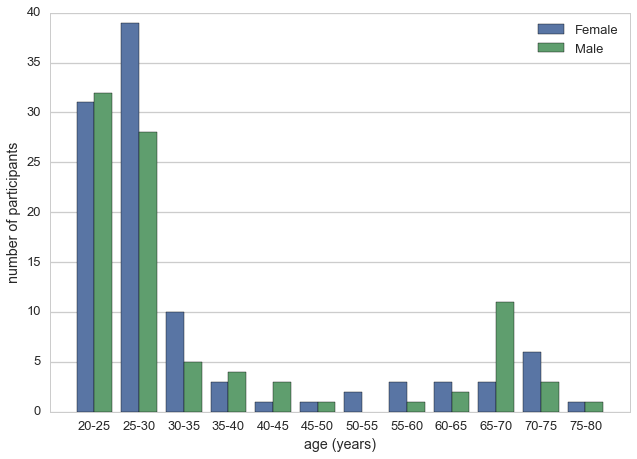

In [10]:
fig = sns.countplot(x='age (5-year bins)', hue='gender', 
              data=df_fig.sort_values(by=['age (5-year bins)'], ascending=[1]))
fig.legend(loc='upper right')
fig.axes.legend(('Female', 'Male'))
fig.set_xlabel('age (years)')
fig.set_ylabel('number of participants')
f = fig.get_xticklabels()
fig.set_xticklabels(f[0:12])
fig.set_xlim([-1,12])

plt.savefig("Figure_distribution.svg")
plt.savefig("Figure_distribution.pdf")
plt.savefig("Figure_distribution.png")
plt.show()

In [ ]:
#for n in [1, 2]:
#    sns.distplot(df_fig['mean age'][df_fig['gender']==n], kde=True, hist=False)

# sns.violinplot(x='gender', y='mean age', data=df_fig)